In [31]:
class TechnologieWissen:
    def __init__(self, name: str, letzte_verwendung: int):
        self.name = name
        self.letzte_verwendung = letzte_verwendung

    def __repr__(self):
        return f"{self.name}: vor {self.letzte_verwendung} Tagen"

class MitarbeiterSkills:
    def __init__(self, name: str, technologien: list[TechnologieWissen]):
        self.name = name
        self.technologien = technologien

    def __repr__(self):
        technologien_str = "\n    ".join([repr(t) for t in self.technologien])
        return (
            f"Mitarbeiter:\n"
            f"  Name: {self.name}\n"
            f"  Skills:\n"
            f"    {technologien_str}"
        )
    
    def to_embedding(self):
        # Konvertiere die Technologien in eine Liste von Strings
        technologien_str = [t.name for t in self.technologien]
        # Erstelle ein Embedding aus den Technologien
        return " ".join(technologien_str)

In [32]:
import json
import random

with open("technologien.json", "r", encoding="utf-8") as f:
    technologien = json.load(f)
with open("namen.json", "r", encoding="utf-8") as f:
    namen = json.load(f)

def get_random_skills():
    skills = []
    for _ in range(1, random.randint(1, 5) + 1):
        tech_name = random.choice(technologien)
        skills.append(TechnologieWissen(tech_name, random.randint(0, 2 * 365)))
    return skills

### Zufällige Farben für die Technologien generieren um den Plot später besser zu visualisieren

In [33]:
import matplotlib.colors as mcolors

def random_color():
    return [random.random(), random.random(), random.random()]

# Erzeuge für jede Technologie eine zufällige Farbe
tech_colors = {tech: random_color() for tech in technologien}

# Beispielausgabe
for tech, color in tech_colors.items():
    print(f"{tech}: {color}")


Python: [0.16239862642027414, 0.36794818211447233, 0.4893567272510637]
JavaScript: [0.9062741146033189, 0.34379358539661664, 0.6696532100380379]
Java: [0.5598373663421286, 0.6217498413442779, 0.30487388272066307]
C#: [0.2696986630766611, 0.9084046514277896, 0.271849822239405]
Ruby: [0.9737361009639742, 0.43755522001333036, 0.6403054279285109]
Go: [0.053750032644118595, 0.7759455032195776, 0.868191178921478]
Rust: [0.6934553621634526, 0.9166455744135611, 0.2687271984005277]
Kotlin: [0.7244238188566221, 0.8147893780362158, 0.5228561179319088]
Swift: [0.8600541986711262, 0.9633217436017064, 0.45478741312063]
PHP: [0.6434358349864057, 0.709821131942376, 0.596504109447585]
TypeScript: [0.8822880927405276, 0.4483968825855138, 0.6604418566248937]
Django: [0.6014682701522093, 0.20401253457544644, 0.2548365206470038]
Flask: [0.8979449554493727, 0.04783878286059218, 0.44775280859143707]
React: [0.9439920644060206, 0.08727819316644747, 0.14074073057662018]
Angular: [0.08894090977763658, 0.5991969

## Formatieren der Daten

In [34]:
data: list[MitarbeiterSkills] = []

for name in namen:
    skills = get_random_skills()
    mitarbeiter = MitarbeiterSkills(name, skills)
    data.append(mitarbeiter)

for ma in data:
    print(ma)

Mitarbeiter:
  Name: Laura Müller
  Skills:
    GitHub: vor 680 Tagen
Mitarbeiter:
  Name: Maximilian Schmidt
  Skills:
    PHP: vor 197 Tagen
Mitarbeiter:
  Name: Anna Fischer
  Skills:
    MySQL: vor 446 Tagen
    Power BI: vor 419 Tagen
    Go: vor 288 Tagen
    Ruby: vor 408 Tagen
Mitarbeiter:
  Name: Jonas Wagner
  Skills:
    PHP: vor 536 Tagen
    SQL: vor 299 Tagen
    Vue.js: vor 254 Tagen
Mitarbeiter:
  Name: Sofia Hofmann
  Skills:
    TypeScript: vor 504 Tagen
    PyTorch: vor 597 Tagen
    Scikit-learn: vor 698 Tagen
    JavaScript: vor 402 Tagen
    Terraform: vor 291 Tagen
Mitarbeiter:
  Name: Paul Klein
  Skills:
    Pandas: vor 215 Tagen
    MySQL: vor 155 Tagen
    GitHub: vor 36 Tagen
Mitarbeiter:
  Name: Emma Lehmann
  Skills:
    Keras: vor 33 Tagen
Mitarbeiter:
  Name: Liam Becker
  Skills:
    Kubernetes: vor 716 Tagen
Mitarbeiter:
  Name: Mia Krüger
  Skills:
    Kotlin: vor 548 Tagen
Mitarbeiter:
  Name: Noah Wolf
  Skills:
    Terraform: vor 651 Tagen
    Expr

## Erstellen der Vektoren (Embeddings)

In [35]:
from openai import OpenAI

client = OpenAI()

def embedded_data(data):
    return client.embeddings.create(input=data, model="text-embedding-3-small").data[0].embedding

In [36]:
embedded_data = []

for ma in data:
    embedded_data.append(
        client.embeddings.create(input=ma.to_embedding(), model="text-embedding-3-small").data[0].embedding
    )

## Erstellen der Vektordatenbank

In [37]:
import faiss
import numpy as np

dim = len(embedded_data[0])
index = faiss.IndexFlatL2(dim)

embeddings_np = np.array(embedded_data).astype("float32")
index.add(embeddings_np)

## Suche in der Vektordatenbank

In [42]:
query = "Frontend Technologien"
query_vector = client.embeddings.create(input=query, model="text-embedding-3-small").data[0].embedding

search_vector = np.array([query_vector]).astype('float32')

erg_anzahl = 5

D, indices = index.search(search_vector, erg_anzahl)

print(f"Distances: {D}")
print(f"Indices: {indices}")

for i in indices[0]:
    print(data[i])

Distances: [[1.1815264 1.210161  1.2129974 1.2282319 1.2311914]]
Indices: [[ 70 154 124 149  91]]
Mitarbeiter:
  Name: Linus Bach
  Skills:
    Express.js: vor 457 Tagen
Mitarbeiter:
  Name: Matthias Neumann
  Skills:
    Salesforce: vor 462 Tagen
    Google Cloud: vor 569 Tagen
    JavaScript: vor 64 Tagen
    Node.js: vor 34 Tagen
    Python: vor 104 Tagen
Mitarbeiter:
  Name: Jonathan Höfer
  Skills:
    AWS: vor 310 Tagen
    React: vor 100 Tagen
Mitarbeiter:
  Name: Beate Behrens
  Skills:
    Express.js: vor 709 Tagen
    Flask: vor 518 Tagen
    PHP: vor 238 Tagen
    Swift: vor 68 Tagen
Mitarbeiter:
  Name: Alicia Brandt
  Skills:
    JavaScript: vor 585 Tagen


## Darstellen mit t-SNE

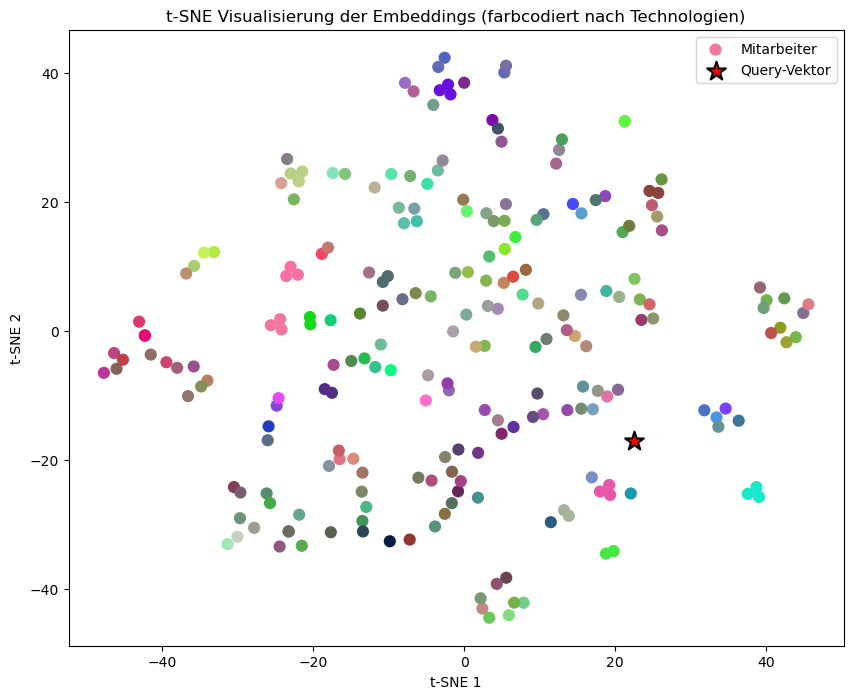

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Kombiniere Embeddings und Query-Vektor für t-SNE
all_embeddings = np.vstack([embeddings_np, search_vector])
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
reduced_all = tsne.fit_transform(all_embeddings)
reduced_embeddings = reduced_all[:-1]
query_tsne = reduced_all[-1]

# Berechne für jeden Mitarbeiter die Mischfarbe seiner Technologien
def mix_colors(techs):
    colors = [tech_colors[t.name] for t in techs if t.name in tech_colors]
    if colors:
        return np.mean(colors, axis=0)
    else:
        return [0.5, 0.5, 0.5]  # Grau als Fallback

point_colors = [mix_colors(ma.technologien) for ma in data]

# Plotten der reduzierten Embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], s=60, c=point_colors, label="Mitarbeiter")
plt.scatter(query_tsne[0], query_tsne[1], s=200, c="red", marker="*", edgecolor="black", linewidths=1.5, label="Query-Vektor")

# Optional: Titel und Achsenbeschriftungen hinzufügen
plt.title("t-SNE Visualisierung der Embeddings (farbcodiert nach Technologien)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.show()